# Attentative Neural Processes
This note book will test attentative neural processes (ANP) on both the 1D regression task and inpainting for only the chroma channels of an image.

## Imports
Import needed for both tasks.

In [0]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import collections

#### Multihead attention
The version below is supposed to be more optimized but provides a very noisy
result and isn't much faster so it is commented out.

In [0]:
# class MultiheadAttention(nn.Module):
#     """
#     Multihead attention mechanism (dot attention)
#     """
#     def __init__(self, num_hidden_k):
#         """
#         :param num_hidden_k: dimension of hidden 
#         """
#         super(MultiheadAttention, self).__init__()

#         self.num_hidden_k = num_hidden_k
#         self.attn_dropout = nn.Dropout(p=0.1)

#     def forward(self, key, value, query):
#         # Get attention score
#         attn = torch.bmm(query, key.transpose(1, 2))
#         attn = attn / np.sqrt(self.num_hidden_k)
        
#         attn = torch.softmax(attn, dim=-1)

#         # Dropout
#         # attn = self.attn_dropout(attn)
        
#         # Get Context Vector
#         result = torch.bmm(attn, value)

#         return result, attn


# class Attention(nn.Module):
#     """
#     Attention Network
#     """
#     def __init__(self, input_size, key_sizes, query_sizes, repr_size, num_hidden, h=4):
#         """
#         :param num_hidden: dimension of hidden
#         :param h: num of heads 
#         """
#         super(Attention, self).__init__()
#         # print(key_sizes, query_sizes)

#         self.num_hidden = num_hidden
#         self.num_hidden_per_attn = num_hidden // h
#         self.h = h

#         query = [nn.Linear(input_size, query_sizes[0]), nn.ReLU(inplace=True)]
#         for i in range(1, len(query_sizes)):
#             query += [nn.Linear(query_sizes[i - 1], query_sizes[i])]
#             if i != len(query_sizes) - 1:
#                 query += [nn.ReLU(inplace=True)]

#         self.query = nn.Sequential(*query)

#         key = [nn.Linear(input_size, key_sizes[0]), nn.ReLU(inplace=True)]
#         for i in range(1, len(key_sizes)):
#             key += [nn.Linear(key_sizes[i - 1], key_sizes[i])]
#             if i != len(key_sizes) - 1:
#                 key += [nn.ReLU(inplace=True)]

#         self.key = nn.Sequential(*key)
#         #self.key = nn.Linear(d_k, num_hidden, bias=False)
#         self.value = nn.Linear(repr_size, num_hidden, bias=False)
#         #self.query = nn.Linear(d_q, num_hidden, bias=False)

#         self.multihead = MultiheadAttention(self.num_hidden_per_attn)

#         self.residual_dropout = nn.Dropout(p=0.1)

#         self.final_linear = nn.Linear(num_hidden, num_hidden)

#         self.layer_norm = nn.LayerNorm(num_hidden)

#     def forward(self, key, value, query):

#         batch_size = key.size(0)
#         seq_k = key.size(1)
#         seq_q = query.size(1)
#         # residual = query
        
#         # Make multihead
#         # print(key.shape)
#         # print(value.shape)
#         # print(query.shape)
#         key = self.key(key).view(batch_size, seq_k, self.h, self.num_hidden_per_attn)
#         value = self.value(value).view(batch_size, seq_k, self.h, self.num_hidden_per_attn)
#         query = self.query(query).view(batch_size, seq_q, self.h, self.num_hidden_per_attn)
#         residual = query.contiguous().view(batch_size, seq_q, -1)

#         key = key.permute(2, 0, 1, 3).contiguous().view(-1, seq_k, self.num_hidden_per_attn)
#         value = value.permute(2, 0, 1, 3).contiguous().view(-1, seq_k, self.num_hidden_per_attn)
#         query = query.permute(2, 0, 1, 3).contiguous().view(-1, seq_q, self.num_hidden_per_attn)

#         # Get context vector
#         result, attns = self.multihead(key, value, query)

#         # Concatenate all multihead context vector
#         result = result.view(self.h, batch_size, seq_q, self.num_hidden_per_attn)
#         result = result.permute(1, 2, 0, 3).contiguous().view(batch_size, seq_q, -1)
        
#         # Concatenate context vector with input (most important)
#         # result = torch.cat([residual, result], dim=-1)
        
#         # Final linear
#         result = self.final_linear(result)

#         # Residual dropout & connection
#         # result = self.residual_dropout(result)
#         # result = result + residual

#         # Layer normalization
#         # result = self.layer_norm(result)

#         return result, attns

#### Multihead attention
Multihead attention that uses dot product attention for each head.
Code can still be optimized but need to figure out what is slowing it down.

Code below is based off of the tensorflow code from DeepMind which can be accessed [here](https://github.com/deepmind/neural-processes/blob/master/attentive_neural_process.ipynb).

In [0]:
def dot_product_attention(q, k, v):
    """
    Computes dot product attention.

    @param q: queries. tensor of  shape [B,m,d_k].
    @param k: keys. tensor of shape [B,n,d_k].
    @param v: values. tensor of shape [B,n,d_v].

    @return tensor of shape [B,m,d_v].
    """
    d_k = q.size(-1)
    scale = np.sqrt(d_k)
    # need to permute because channels needs to be the last channel for this operation
    k = k.permute(0, 2, 1)
    q = q.permute(0, 2, 1)
    v = v.permute(0, 2, 1)
    unnorm_weights = torch.einsum('bjk,bik->bij', k, q) / scale  # [B,m,n]
    weights = F.softmax(unnorm_weights, dim=-1)  # [B,m,n]
    rep = torch.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
    # permute shape back so that it can be 
    rep = rep.permute(0, 2, 1)
    return rep


class MultiheadAttention(nn.Module):
    def __init__(self, num_heads, d_k, d_q, d_v):
        """
        Constructor for Multihead attention module.

        @param num_heads: number of heads to use.
        @param d_k: size of key.
        @param d_q: size of query.
        @param d_v: size of value.
        """
        super(MultiheadAttention, self).__init__()
        head_size = d_v // num_heads
        self.num_heads = num_heads

        heads = nn.ModuleDict()
        for i in range(num_heads):
            heads['head' + str(i) + '_key'] = nn.Conv1d(d_k, head_size, 1, bias=False)
            heads['head' + str(i) + '_query'] = nn.Conv1d(d_q, head_size, 1, bias=False)
            heads['head' + str(i) + '_value'] = nn.Conv1d(d_v, head_size, 1, bias=False)
            heads['head' + str(i) + '_fc'] = nn.Conv1d(head_size, d_v, 1, bias=False)

        self.heads = heads


    def forward(self, q, k, v):
        """
        Computes multihead attention.

        @param q: queries. tensor of  shape [B,m,d_k].
        @param k: keys. tensor of shape [B,n,d_k].
        @param v: values. tensor of shape [B,n,d_v].

        @return tensor of shape [B,m,d_v].
        """
        rep = 0.
        for i in range(self.num_heads):
            key = self.heads['head' + str(i) + '_key'](k)
            query = self.heads['head' + str(i) + '_query'](q)
            value = self.heads['head' + str(i) + '_value'](v)
            output = dot_product_attention(query, key, value)
            rep += self.heads['head' + str(i) + '_fc'](output)
        return rep

class Attention(nn.Module):
    def __init__(self, key_sizes, query_sizes, repr_size, att_type, num_heads=8):
        """
        Constructor for attention module

        @param key_sizes: sizes used for layers in mlp
        @param query_sizes: sizes used for layers in mlp
        @param repr_size: representation size used for multihead attention
        @param att_type: type of attention (multihead or dot product)
        @param num_heads: number of heads for multihead attention
        """
        super(Attention, self).__init__()

        query = []
        for i in range(1, len(query_sizes)):
            query += [nn.Linear(query_sizes[i - 1], query_sizes[i])]
            if i != len(query_sizes) - 1:
                query += [nn.ReLU(inplace=True)]

        self.query = nn.Sequential(*query)

        key = []
        for i in range(1, len(key_sizes)):
            key += [nn.Linear(key_sizes[i - 1], key_sizes[i])]
            if i != len(key_sizes) - 1:
                key += [nn.ReLU(inplace=True)]

        self.key = nn.Sequential(*key)
        
        self.att_type = att_type
        if att_type == 'multihead':
            self.multihead = MultiheadAttention(num_heads, key_sizes[-1], query_sizes[-1], repr_size)


    def forward(self, context_x, target_x, r):
        """
        Compute attention given a key (context_x), representation (r), and query (target_x)

        @param context_x: key tensor with shape [B, num_context_points, input_size]
        @param target_x: query tensor with shape [B, num_predict_points, input_size]
        @param r: representation tensor with shape [B, num_context_points, repr_size]

        @return a tensor for the new representation [B, num_predict_points, repr_size]
        """
        k = self.key(context_x)
        q = self.query(target_x)

        if self.att_type == 'dot_product':
            rep = dot_product_attention(q, k, r)
        elif self.att_type == 'multihead':
            q = q.permute(0, 2, 1).contiguous()
            k = k.permute(0, 2, 1).contiguous()
            r = r.permute(0, 2, 1).contiguous()
            rep = self.multihead(q, k, r)
            rep = rep.permute(0, 2, 1).contiguous()

        return rep

## Model for ANP
This code is also based off of the [DeepMind code](https://github.com/deepmind/neural-processes/blob/master/attentive_neural_process.ipynb).

#### Decoder


In [0]:
class DeterministicDecoder(nn.Module):
    def __init__(self, output_sizes):
        """
        Constructor for decoder

        @param output_sizes: sizes of each layer in mlp for decoder
        """
        super(DeterministicDecoder, self).__init__()

        decoder = []
        for i in range(1, len(output_sizes)):
            decoder += [nn.Linear(output_sizes[i - 1], output_sizes[i])]
            if i != len(output_sizes) - 1:
                decoder += [nn.ReLU(inplace=True)]

        self.decoder = nn.Sequential(*decoder)

    def forward(self, repr, x):
        """
        Forward pass for decoder

        @param repr: represenation to use for decoder [B, 2 * output_encoder_size, context_x_size + context_y_size]
        @param x: target_x we want to predict values with size [B, num_target_points, target_x_size]

        @return multivariate normal distrubtion for each predicted point
        @return mu (mean) for distribution
        @return sigma (variance) for distribution
        """
        output = torch.cat([repr, x], dim=-1)
        output = self.decoder(output)
        mu, log_sigma = torch.chunk(output, 2, dim=-1)

        sigma = 0.1 + 0.9 * F.softplus(log_sigma)

        dist = torch.distributions.multivariate_normal.MultivariateNormal(mu, covariance_matrix=torch.diag_embed(sigma))

        return dist, mu, sigma

#### Latent Encoder

In [0]:
class LatentEncoder(nn.Module):
    def __init__(self, output_sizes, num_latent):
        """
        Constructor for latent encoder

        @param output_sizes: sizes of each layer in mlp for latent encoder
        @param num_latent: size of latent variable
        """
        super(LatentEncoder, self).__init__()

        encoder = []
        for i in range(1, len(output_sizes)):
            encoder += [nn.Linear(output_sizes[i - 1], output_sizes[i])]
            if i != len(output_sizes) - 1:
                encoder += [nn.ReLU(inplace=True)]

        self.encoder = nn.Sequential(*encoder)
        self.fc = nn.Sequential(nn.Linear(output_sizes[-1], (output_sizes[-1] + num_latent) // 2),
                                nn.ReLU(inplace=True),
                                nn.Linear((output_sizes[-1] + num_latent) // 2, 2 * num_latent))

    def forward(self, x, y):
        """
        Forward pass for latent encoder

        @param x: input context_x we are given with size [B, num_context_points, context_x_size]
        @param y: output context_y we are given with size [B, num_context_points, context_y_size]

        @return multivariate normal distrubtion for each latent variable
        @return mu (mean) for distribution
        @return sigma (variance) for distribution
        """
        input = torch.cat([x, y], dim=-1)
        hidden = self.encoder(input)
        hidden = hidden.mean(dim=1)
        output = self.fc(hidden)

        mu, log_sigma = torch.chunk(output, 2, dim=-1)

        sigma = 0.1 + 0.9 * torch.sigmoid(log_sigma)

        dist = torch.distributions.multivariate_normal.MultivariateNormal(mu, covariance_matrix=torch.diag_embed(sigma))

        return dist, mu, sigma

#### Deterministic Encoder

In [0]:
class DeterministicEncoder(nn.Module):
    def __init__(self, output_sizes, key_sizes, query_sizes):
        """
        Constructor for deterministic encoder

        @param output_sizes: sizes of each layer in mlp for deterministic encoder
        @param key_sizes: sizes of each layer in mlp for key for attention
        @param query_sizes: sizes of each layer in mlp for query for attention
        """
        super(DeterministicEncoder, self).__init__()

        encoder = []
        for i in range(1, len(output_sizes)):
            encoder += [nn.Linear(output_sizes[i - 1], output_sizes[i])]
            if i != len(output_sizes) - 1:
                encoder += [nn.ReLU(inplace=True)]

        self.encoder = nn.Sequential(*encoder)
        self.attention = Attention(key_sizes, query_sizes, output_sizes[-1], att_type='multihead')
        # self.attention = Attention(1, key_sizes, query_sizes, output_sizes[-1], output_sizes[-1], h=8)

    def forward(self, context_x, context_y, target_x):
        """
        Forward pass for deterministic encoder

        @param context_x: input context_x we are given with size [B, num_context_points, context_x_size]
        @param context_y: output context_y we are given with size [B, num_context_points, context_y_size]
        @param target_x: target_x we want to predict values for with size [B, num_target_points, context_x_size]

        @return representation for context points given the target point as a query
        """
        encoder_input = torch.cat([context_x, context_y], dim=-1)
        hidden = self.encoder(encoder_input)
        repr = self.attention(context_x, target_x, hidden)
        # repr, _ = self.attention(context_x, hidden, target_x)

        return repr

#### ANP entire model

In [0]:
class Model(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes, key_sizes, query_sizes, num_latent):
        """
        Constructor for ANP model

        @param encoder_sizes: sizes of each layer of mlp in both encoders
        @param decoder_sizes: sizes of each layer of mlp in decoder
        @param key_sizes: sizes of each layer in mlp for key for attention
        @param query_sizes: sizes of each layer in mlp for query for attention
        @param num_latent: size of latent variable
        """
        super(Model, self).__init__()
        self.latent_encoder = LatentEncoder(encoder_sizes, num_latent)
        self.determ_encoder = DeterministicEncoder(encoder_sizes, key_sizes, query_sizes)
        self.determ_decoder = DeterministicDecoder(decoder_sizes)
    
    def forward(self, query, num_targets, target_y=None):
        """
        Forward pass for ANP

        @param query: tuple which contains (context_x, context_y) and target_X
        @param num_targets:  number of target points to predict
        @param target_y: desired points (only available at train time)

        @return mu (mean) for learned distributions
        @return sigma (variance) for learned distributions
        @return log probability that target_y in distribution
        @return kl divergence between latent posterior and prior
        @return loss for the model
        """
        (context_x, context_y), target_x = query

        # Pass query through the encoder and the decoder
        prior, _, _ = self.latent_encoder(context_x, context_y)
        
        # For training, when target_y is available, use targets for latent encoder.
        # Note that targets contain contexts by design.
        if target_y is None:
            latent_rep = prior.sample()
        # For testing, when target_y unavailable, use contexts for latent encoder.
        else:
            posterior, _, _ = self.latent_encoder(target_x, target_y)
            latent_rep = posterior.sample()
            latent_rep = latent_rep.unsqueeze(1).repeat(1, num_targets, 1)

        deterministic_rep = self.determ_encoder(context_x, context_y, target_x)
        representation = torch.cat([deterministic_rep, latent_rep], dim=-1)

        dist, mu, sigma = self.determ_decoder(representation, target_x)
        
        # If we want to calculate the log_prob for training we will make use of the
        # target_y. At test time the target_y is not available so we return None.
        if target_y is not None:
            log_p = dist.log_prob(target_y)
            posterior, _, _ = self.latent_encoder(target_x, target_y)
            kl = torch.sum(
                torch.distributions.kl.kl_divergence(posterior, prior), 
                dim=-1, keepdim=True)
            kl = kl.repeat(1, num_targets)
            loss = -torch.mean(log_p - kl / num_targets)
        else:
            log_p = None
            kl = None
            loss = None

        return mu, sigma, log_p, kl, loss

## Testing with 1D regression

Dataset is based off of the regression code from [here](https://github.com/deepmind/neural-processes/blob/master/attentive_neural_process.ipynb).


#### Dataset

In [0]:
CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))

In [0]:
class GPCurvesReader(object):
    def __init__(self, batch_size, max_num_context, x_size=1, y_size=1, l1_scale=0.4, sigma_scale=1.0, testing=False):
        '''
        Creates a regression dataset of functions samples from a GP.

        @param batch_size: An integer.
        @param max_num_context: The max number of observations in the context.
        @param x_size: Integer >= 1 for length of "x values" vector.
        @param y_size: Integer >= 1 for length of "y values" vector.
        @param l1_scale: Float; typical scale for kernel distance function.
        @param sigma_scale: Float; typical scale for variance.
        @param testing: Boolean that indicates whether we are testing. If so there are
            more targets for visualization.
        '''
        self.batch_size = batch_size
        self.max_num_context = max_num_context
        self.x_size = x_size
        self.y_size = y_size
        self.l1_scale = l1_scale
        self.sigma_scale = sigma_scale
        self.testing = testing

    def gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        '''
        Applies the Gaussian kernel to generate curve data

        @param xdata: tensor with shape `[batch_size, num_total_points, x_size]` with
            the values of the x-axis data.
        @param l1: tensor with shpae `[batch_size, y_size, x_size]`, the scale parameter of the
            Gaussian kernel.
        @param sigma_f: float tensor with shpae `[batch_size, y_size]`, the magnitude of the std.
        @param sigma_noise: float, std of the noise we add for stability
        @return kernel: float tensor with shape `[batch_size, y_size, num_total_points, num_total_points]`.
        '''
        num_total_points = xdata.size(1)

        # Expand and take the difference
        xdata1 = xdata.unsqueeze(1)
        xdata2 = xdata.unsqueeze(2)
        diff = xdata1 - xdata2

        norm = (diff[:,None,:,:,:] / l1[:,:,None,None,:]) ** 2

        norm = torch.sum(norm, dim=-1)

        kernel = ((sigma_f) ** 2)[:,:,None,None] * torch.exp(-0.5 * norm)

        kernel += (sigma_noise ** 2) * torch.eye(num_total_points)

        return kernel

    def generate_curves(self):
        '''
        Builds the op delivering the data.
        Generated functions are `float32` with x values between -2 and 2.

        @return A `CNPRegressionDescription` namedtuple.
        '''
        num_context = torch.randint(low=3, high=self.max_num_context+1, size=(1,)).item()

        if self.testing:
            num_target = 400
            num_total_points = num_target
            #x_values = torch.arange(-2., 2., 1. / 100, dtype=torch.float32).unsqueeze(0).repeat(1, self.batch_size, 1)
            x_values = torch.arange(-2., 2., 1. / 100, dtype=torch.float32).unsqueeze(0).repeat(self.batch_size, 1)
            x_values = x_values.unsqueeze(-1)
        else:
            num_target = torch.randint(low=2, high=self.max_num_context+1, size=(1, )).item()
            num_total_points = num_context + num_target
            # generate x_values between -2 and 2
            x_values = torch.rand((self.batch_size, num_total_points, self.x_size))
            x_values = 4 * x_values - 2

        l1 = torch.ones(self.batch_size, self.y_size, self.x_size) * self.l1_scale
        
        sigma_f = torch.ones(self.batch_size, self.y_size) * self.sigma_scale

        kernel = self.gaussian_kernel(x_values, l1, sigma_f)

        cholesky = torch.cholesky(kernel.type(torch.DoubleTensor)).type(torch.FloatTensor)

        y_values = torch.matmul(cholesky, torch.randn(self.batch_size, self.y_size, num_total_points, 1))

        y_values = y_values.squeeze(3).permute(0, 2, 1)

        if self.testing:
            target_x = x_values
            target_y = y_values

            #idx = torch.from_numpy(np.random.permutation(np.arange(num_target)))
            idx = torch.randperm(num_target)
            context_x = torch.gather(x_values, 1, idx[None,:num_context,None]) # fix it
            context_y = torch.gather(y_values, 1, idx[None,:num_context,None]) # fit it
        else:
            target_x = x_values[:,:num_target + num_context, :]
            target_y = y_values[:,:num_target + num_context, :]

            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)

        return CNPRegressionDescription(query=query, target_y=target_y, num_total_points=target_x.size(1), num_context_points=num_context)


#### Function to plot curves

In [0]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):
    """
    Plots the predicted mean and variance and the context points.
     
    @param target_x: An array of shape batchsize x number_targets x 1 that contains the
            x values of the target points.
    @param target_y: An array of shape batchsize x number_targets x 1 that contains the
            y values of the target points.
    @param context_x: An array of shape batchsize x number_context x 1 that contains 
            the x values of the context points.
    @param context_y: An array of shape batchsize x number_context x 1 that contains 
            the y values of the context points.
    @param pred_y: An array of shape batchsize x number_targets x 1  that contains the
            predicted means of the y values at the target points in target_x.
    @param pred_y: An array of shape batchsize x number_targets x 1  that contains the
            predicted variance of the y values at the target points in target_x.
    """
    # Plot everything
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
    plt.fill_between(
        target_x[0, :, 0],
        pred_y[0, :, 0] - var[0, :, 0],
        pred_y[0, :, 0] + var[0, :, 0],
        alpha=0.2,
        facecolor='#65c9f7',
        interpolate=True)

    # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid('off')
    ax = plt.gca()
    ax.set_facecolor('white')
    plt.show()

#### Hyperparameters Part 1

In [0]:
TRAINING_ITERATIONS = int(2e5)
MAX_CONTEXT_POINTS = 10
PLOT_AFTER = 500 #int(2e4)

#### Load datasets

In [0]:
# Train dataset
dataset_train = GPCurvesReader(
    batch_size=64, max_num_context=MAX_CONTEXT_POINTS)

# Test dataset
dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True)

#### Hyperparameters Part 2 + Model creation

In [0]:
num_latent = 128
# 2 is because of context_x and context_y sizes
encoder_sizes = [2] + [128] * 4
# 2 * 128 + 1 is the two encoders + the target_x size
decoder_sizes = [2 * 128 + 1] + [128] * 2 + [2]
# 1 is the context_x size
key_sizes = [1] + [128] * 2
# 1 is the target_x size
query_sizes = [1] + [128] * 2
model = Model(encoder_sizes, decoder_sizes, key_sizes, query_sizes, num_latent)

#### Train model

Iteration: 0, loss: 1.3874109983444214


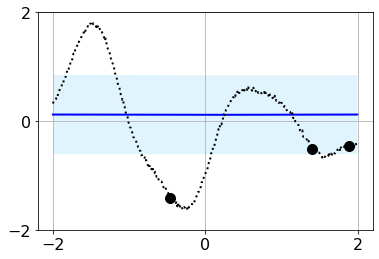

Iteration: 500, loss: 0.5426897406578064


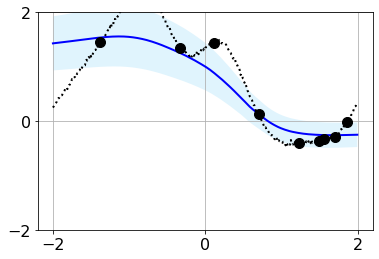

Iteration: 1000, loss: 0.6363760232925415


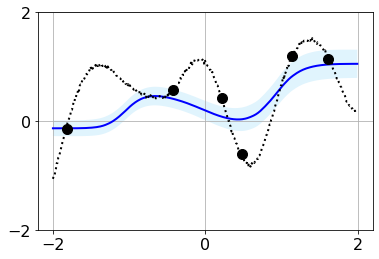

Iteration: 1500, loss: 0.3595845699310303


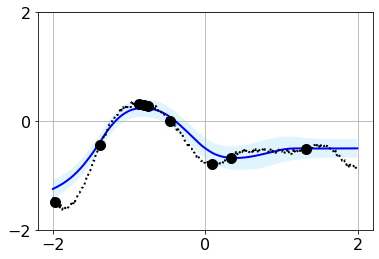

Iteration: 2000, loss: 0.7762039303779602


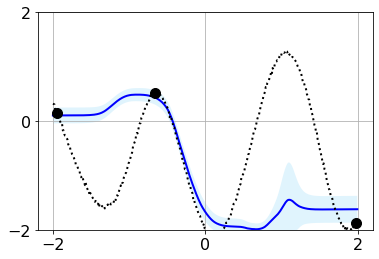

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for it in range(TRAINING_ITERATIONS):
    data_train = dataset_train.generate_curves()
    data_test = dataset_test.generate_curves()
    optimizer.zero_grad()

    #print(data_train.query[0][0].shape, data_train.query[0][1].shape)
    _, _, _, _, loss = model(data_train.query, data_train.num_total_points, data_train.target_y)
    mu, sigma, _, _, _ = model(data_test.query, data_test.num_total_points, data_test.target_y)

    loss.backward()
    optimizer.step()

    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:

        (context_x, context_y), target_x = data_test.query
        print('Iteration: {}, loss: {}'.format(it, loss))

        # Plot the prediction and the context
        plot_functions(target_x.detach().numpy(), data_test.target_y.detach().numpy(), context_x.detach().numpy(), 
                    context_y.detach().numpy(), mu.detach().numpy(), sigma.detach().numpy())
        
    if it == 2000:
        break

## Testing with inpainting
### Get data

Getting data pulled from this [repo](https://github.com/aditya12agd5/divcolor). Only run this cell if the data hasn't been downloaded yet.

In [15]:
!wget http://vision.cs.illinois.edu/projects/divcolor/data.zip
!unzip -qq data.zip
!rm data.zip
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar -xzf lfw-deepfunneled.tgz
!mv lfw-deepfunneled data/lfw_images
!rm lfw-deepfunneled.tgz

--2020-04-26 06:04:09--  http://vision.cs.illinois.edu/projects/divcolor/data.zip
Resolving vision.cs.illinois.edu (vision.cs.illinois.edu)... 18.220.149.166
Connecting to vision.cs.illinois.edu (vision.cs.illinois.edu)|18.220.149.166|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3582049892 (3.3G) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   3.34G  30.1MB/s    in 1m 54s  

2020-04-26 06:06:03 (30.0 MB/s) - ‘data.zip’ saved [3582049892/3582049892]

replace data/testimgs/ILSVRC2012_test_00000066.JPEG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
--2020-04-26 06:07:24--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz’

lfw-deepfunnel

### Dataloader

Performs coordinate encoding and converts images to LAB color format.

In [0]:
class colordata(Dataset):
    def __init__(self, basedir, listdir, shape=(32,32), obs_num=100, split='train'):

        self.img_fns = []
        
        self.basedir = basedir
        with open('%s/list.%s.vae.txt' % (os.path.join(basedir, listdir), split), 'r') as ftr:
            for img_fn in ftr:
                self.img_fns.append(img_fn.strip('\n'))

        self.img_num = len(self.img_fns)
        self.shape = shape
        self.obs_num = obs_num # Number of observations
        
        # Create mapping from (x,y) coordinates to positional encodings
        self.x_enc, self.y_enc = self.create_position_encodings(size=shape[0])
        self.x_enc = torch.from_numpy(self.x_enc)
        self.y_enc = torch.from_numpy(self.y_enc)
        
        # Create list of all possible (x,y) coordinates
        self.x_coords, self.y_coords = torch.meshgrid(torch.arange(self.shape[0]), torch.arange(self.shape[1]))
        self.x_coords = self.x_coords.contiguous().view(-1)
        self.y_coords = self.y_coords.contiguous().view(-1)

    def __len__(self):
        return self.img_num
 
    def __getitem__(self, idx):
        img_large = cv2.imread(os.path.join(self.basedir, self.img_fns[idx]))
        if self.shape is not None:
            img = cv2.resize(img_large, (self.shape[0], self.shape[1]))

        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) # convert to lab color space

        img_lab = ((img_lab * 2.) / 255.) - 1. #normalizing
        img_lab = torch.from_numpy(img_lab)

        color_ab = torch.stack(
            (img_lab[..., 1], img_lab[..., 2]), dim=0)
        
        return color_ab, img_lab[..., 0].unsqueeze(0), (self.x_coords, self.y_coords), (self.x_enc, self.y_enc)

    def create_position_encodings(self, size=32):
        H, W, C = size, size, 3

        L = 10 # parameter for size of encoding

        x_linspace = (np.linspace(0, W-1, W)/W)*2 -1 
        y_linspace = (np.linspace(0, H-1, H)/H)*2 -1

        x_el = []
        y_el = []

        x_el_hf = []
        y_el_hf = []

        # cache the values so you don't have to do function calls at every pixel
        for el in range(0, L):
            val = 2 ** el 
            x = np.sin(val * np.pi * x_linspace)
            x_el.append(x)

            x = np.cos(val * np.pi * x_linspace)
            x_el_hf.append(x)

            y = np.sin(val * np.pi * y_linspace)
            y_el.append(y)

            y = np.cos(val * np.pi * y_linspace)
            y_el_hf.append(y)

        x_el = np.array(x_el).T
        x_el_hf = np.array(x_el_hf).T
        y_el = np.array(y_el).T
        y_el_hf = np.array(y_el_hf).T

        return np.hstack((x_el, x_el_hf)), np.hstack((y_el, y_el_hf))


class RandSamplePerBatchCollator(object):
    def __init__(self, high=32*32, minimum_obs_num=64, maximum_obs_num=100):
        self.high = high
        self.minimum_obs_num = minimum_obs_num
        self.maximum_obs_num = maximum_obs_num
        
    def __call__(self, batch):
        obs_num = torch.randint(self.minimum_obs_num, self.maximum_obs_num, (1, )).item()
        obs_indices = torch.randint(0, self.high, (obs_num, ))

        x_coords_obs, y_coords_obs  = [], []
        x_coords_pred, y_coords_pred = [], []
        coords_obs, coords_pred, color_abs, recon_consts = [], [], [], []
        pred_gts = []
        for (color_ab, recon_const, (x_coords, y_coords),
             (x_enc, y_enc)) in batch:
            # L and AB channels
            color_abs.append(color_ab)
            recon_consts.append(recon_const)

            # Observed data
            x_coord_obs = x_coords[obs_indices]
            y_coord_obs = y_coords[obs_indices]
            x_coord_obs_enc = x_enc[x_coord_obs]
            y_coord_obs_enc = y_enc[y_coord_obs]
            color_obs = color_ab[:, x_coord_obs, y_coord_obs]
            coord_obs = torch.cat(
                (x_coord_obs_enc, y_coord_obs_enc, color_obs.t()), dim=-1)

            x_coords_obs.append(x_coord_obs)
            y_coords_obs.append(y_coord_obs)
            coords_obs.append(coord_obs)

            # Predicted data
            x_coords_pred.append(x_coords)
            y_coords_pred.append(y_coords)
            coords_pred.append(torch.cat(
                (x_enc[x_coords], y_enc[y_coords]), dim=-1))
            pred_gt = color_ab[:, x_coords, y_coords]
            pred_gts.append(pred_gt.t())

        color_abs = torch.stack(color_abs, dim=0)
        recon_consts = torch.stack(recon_consts, dim=0)
        x_coords_obs = torch.stack(x_coords_obs, dim=0)
        y_coords_obs = torch.stack(y_coords_obs, dim=0)
        x_coords_pred = torch.stack(x_coords_pred, dim=0)
        y_coords_pred = torch.stack(y_coords_pred, dim=0)
        coords_obs = torch.stack(coords_obs, dim=0)
        coords_pred = torch.stack(coords_pred, dim=0)
        pred_gts = torch.stack(pred_gts, dim=0)

        return (color_abs, recon_consts, coords_obs, coords_pred, pred_gts,
                (x_coords_obs, y_coords_obs), (x_coords_pred, y_coords_pred))


#### Load data and check to see it works

In [17]:
out_dir = 'output/lfw/'
basedir = './'
listdir = 'data/imglist/lfw/'

data_train = colordata(shape = (32,32), basedir=basedir,
                        listdir=listdir, obs_num = 100, split='train')

train_loader = DataLoader(dataset=data_train, num_workers=8,
                            batch_size=32, shuffle=True, drop_last=True, 
                            collate_fn=RandSamplePerBatchCollator())

data_test = colordata(shape = (32,32), basedir=basedir,
    listdir=listdir, obs_num = 100, split='test')

test_loader = DataLoader(dataset=data_test, num_workers=8,
                            batch_size=32, shuffle=False, drop_last=True,
                            collate_fn=RandSamplePerBatchCollator())

# check to make sure that data loader is doing what is expected
for i, (color_c, gray_c, obs, pred, pred_gt,
        (x_coords_obs, y_coords_obs), 
        (x_coords_pred, y_coords_pred)) in enumerate(train_loader):
    print("Color channels (AB) image:")
    print("    ", color_c.shape)
    print("Gray channel (L) image:")
    print("    ", gray_c.shape)
    print("Number of observations coordinates with position encoding (40-dim) and color label (2-dim):")
    print("    ", obs.shape)
    print("Number of predictions coordinates with position encoding (40-dim):")
    print("    ", pred.shape)
    print("Number of predictions coordinates with gt color label(2-dim):")
    print("    ", pred_gt.shape)
    print("(x,y) coordinates of observations: ")
    print("    ", (x_coords_obs.shape, y_coords_obs.shape))
    print("(x,y) coordinates of predictions: ")
    print("    ", (x_coords_pred.shape, y_coords_pred.shape))
    break

Color channels (AB) image:
     torch.Size([32, 2, 32, 32])
Gray channel (L) image:
     torch.Size([32, 1, 32, 32])
Number of observations coordinates with position encoding (40-dim) and color label (2-dim):
     torch.Size([32, 83, 42])
Number of predictions coordinates with position encoding (40-dim):
     torch.Size([32, 1024, 40])
Number of predictions coordinates with gt color label(2-dim):
     torch.Size([32, 1024, 2])
(x,y) coordinates of observations: 
     (torch.Size([32, 83]), torch.Size([32, 83]))
(x,y) coordinates of predictions: 
     (torch.Size([32, 1024]), torch.Size([32, 1024]))


### Visualize learned images code

In [0]:
def decodeimg(img_enc):
    img_dec = (((img_enc+1.)*1.)/2.)*255.
    img_dec[img_dec < 0.] = 0.
    img_dec[img_dec > 255.] = 255.
    return cv2.resize(np.uint8(img_dec), (32,32))

def decodepixels(pixel_enc):
    img_dec = (((pixel_enc+1.)*1.)/2.)*255.
    img_dec[img_dec < 0.] = 0.
    img_dec[img_dec > 255.] = 255.
    return np.uint8(img_dec)

def visualize(gray_c, color_c, coords_obs, coords_pred, mu_a, mu_b, image = 0, out_dir=None):
    image = image # image index to visualize from mini-batch

    x_coords_obs = coords_obs[0]
    y_coords_obs = coords_obs[1]
    # predict coordinates are the entire image
    x_coords_pred = coords_pred[0]
    y_coords_pred = coords_pred[1]

    img_lab = np.zeros((32,32,3), dtype='uint8') 
    img_lab[:,:,0] = decodeimg(gray_c[image].cpu().numpy().reshape((32, 32)))
    img_lab[:,:,1] = decodeimg(color_c[image][0].cpu().numpy().reshape((32, 32)))
    img_lab[:,:,2] = decodeimg(color_c[image][1].cpu().numpy().reshape((32, 32)))

    gt = img_lab.copy()
    obs = img_lab

    img_lab[x_coords_pred[image],y_coords_pred[image],1:2] = decodepixels(mu_a[image].detach().cpu().numpy())
    img_lab[x_coords_pred[image],y_coords_pred[image],2:3] = decodepixels(mu_b[image].detach().cpu().numpy())

    orig_img = cv2.cvtColor(gt, cv2.COLOR_LAB2RGB)
    output_img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

    obs_img = np.zeros((32,32,3), dtype='uint8')
    obs_img[x_coords_obs[image], y_coords_obs[image]]=orig_img[x_coords_obs[image], y_coords_obs[image]]

    plt.subplot(131)
    plt.axis('off'), plt.title("Observation Image")
    plt.imshow(obs_img)
    plt.subplot(132)
    plt.axis('off'), plt.title("Output")
    plt.imshow(output_img)
    plt.subplot(133)
    plt.axis('off'), plt.title("Original GT Image")
    plt.imshow(orig_img)
    if out_dir is not None:
        plt.savefig(out_dir)
    else:
        plt.show()

### Hyperparameters + Model creation

In [0]:
num_latent = 512
# first value of encoder_sizes is 40 for the 40-dim encoding for each coord + 2 for the chroma
encoder_sizes = [42, 128, 256, 512, 512]
# first value of decoder_sizes is 2 * last encoder size + 40 since that is the input target_x value
decoder_sizes = [2 * 512 + 40, 512, 512, 256, 128, 4]
# first value is 40 because of the 40-dim encoding for each coord
key_sizes = [40] + [512] * 2
# first value is 40 because of the 40-dim encoding for each coord
query_sizes = [40] + [512] * 2
model = Model(encoder_sizes, decoder_sizes, key_sizes, query_sizes, num_latent)
model = model.cuda()

#### Train model

Epoch  0
Loss:  -0.38624265789985657


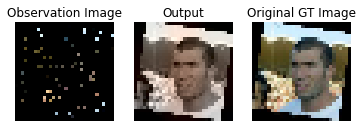

Epoch  0
Loss:  -0.35129918558384055


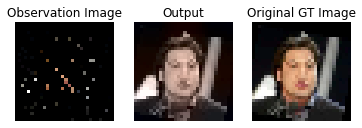

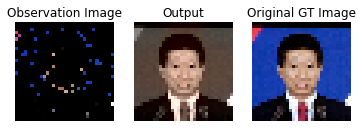

Loss:  -0.3587947319705449
===
Test Epoch  0
Loss:  -0.3790088891983032


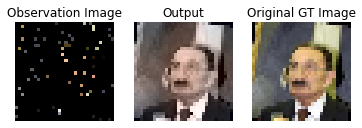

Loss:  -0.35544028878211975


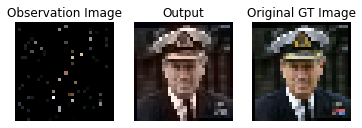

===
Epoch  1
Loss:  -0.34316539764404297


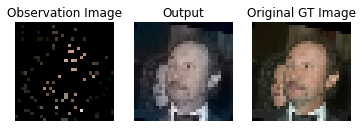

Epoch  1
Loss:  -0.36558040146210896


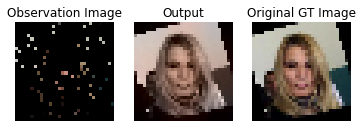

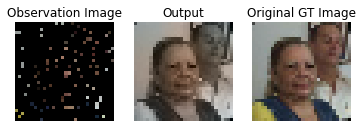

Loss:  -0.3651202669786533
===
Test Epoch  1
Loss:  -0.37823185324668884


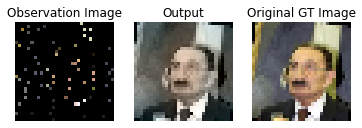

Loss:  -0.36012062430381775


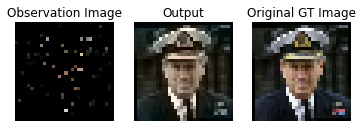

===
Epoch  2
Loss:  -0.29919546842575073


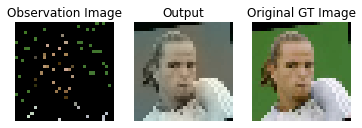

Epoch  2
Loss:  -0.3671304860814887


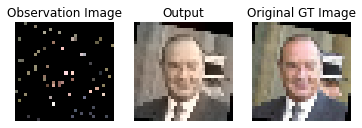

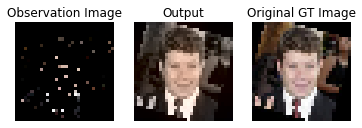

Loss:  -0.3678412964830848
===
Test Epoch  2
Loss:  -0.38549232482910156


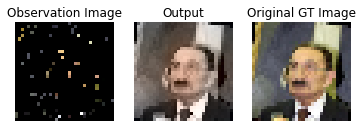

Loss:  -0.37685784697532654


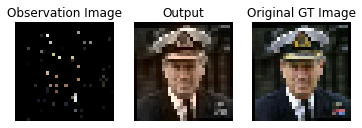

===
Epoch  3
Loss:  -0.3852144479751587


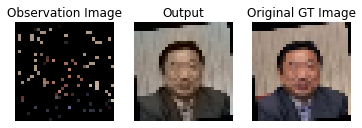

Epoch  3
Loss:  -0.3830231141984759


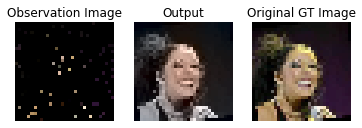

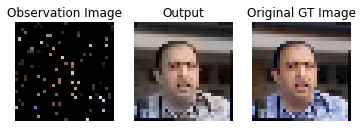

Loss:  -0.3882061312491981
===
Test Epoch  3
Loss:  -0.4014052748680115


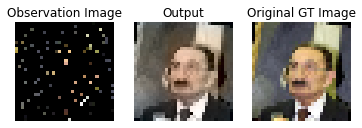

Loss:  -0.3981991410255432


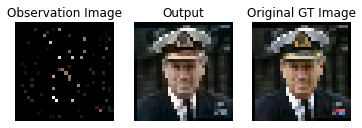

===
Epoch  4
Loss:  -0.3995196223258972


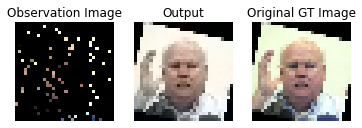

Epoch  4
Loss:  -0.4026828114666156


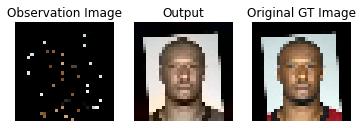

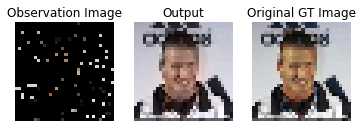

Loss:  -0.4045494413344648
===
Test Epoch  4
Loss:  -0.40962153673171997


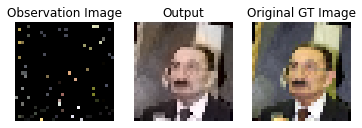

Loss:  -0.4051034450531006


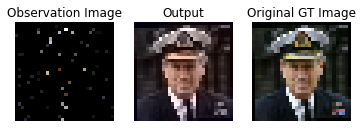

===
Epoch  5
Loss:  -0.40537646412849426


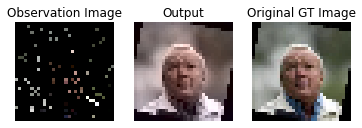

Epoch  5
Loss:  -0.4161755641301473


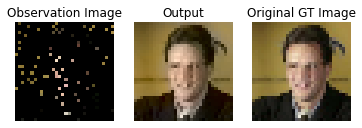

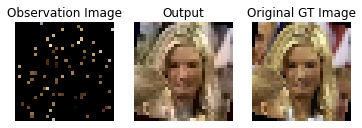

Loss:  -0.41844509776038025
===
Test Epoch  5
Loss:  -0.42462074756622314


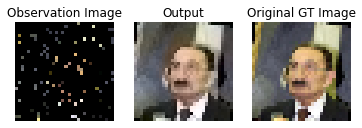

Loss:  -0.42556947469711304


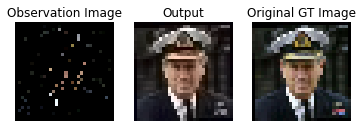

===
Epoch  6
Loss:  -0.41756802797317505


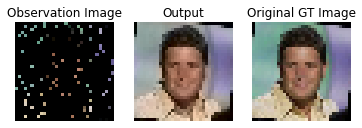

Epoch  6
Loss:  -0.42374248928691616


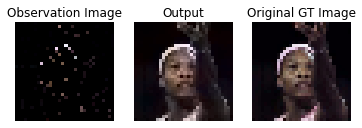

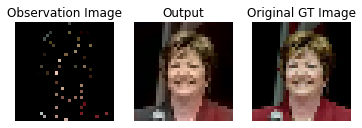

Loss:  -0.4250443635498666
===
Test Epoch  6
Loss:  -0.4315930902957916


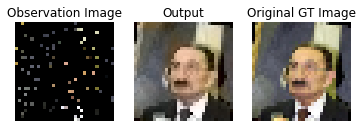

Loss:  -0.42906174063682556


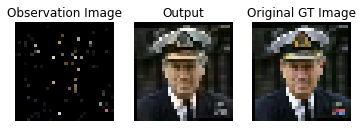

===
Epoch  7
Loss:  -0.4291525185108185


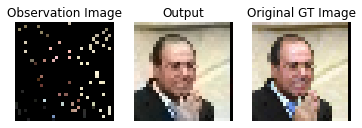

Epoch  7
Loss:  -0.4288541978567987


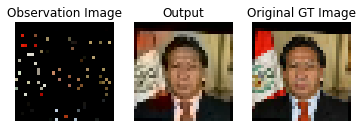

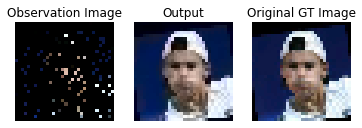

Loss:  -0.4295007506902305
===
Test Epoch  7
Loss:  -0.4315704107284546


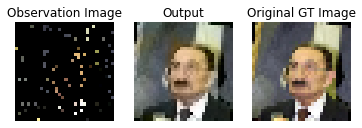

Loss:  -0.4333050549030304


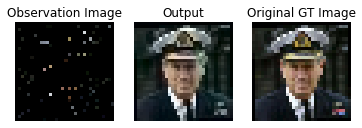

===
Epoch  8
Loss:  -0.4319564998149872


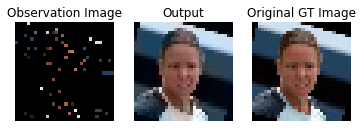

Epoch  8
Loss:  -0.4326762648957286


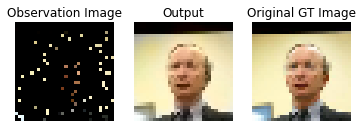

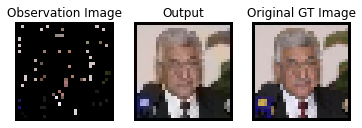

Loss:  -0.4331422132191234
===
Test Epoch  8
Loss:  -0.4362870454788208


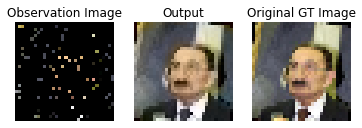

Loss:  -0.4361822009086609


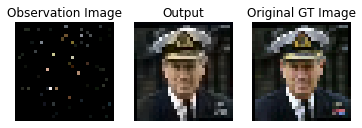

===
Epoch  9
Loss:  -0.4360466003417969


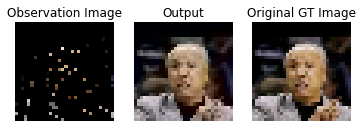

Epoch  9
Loss:  -0.43426707905916434


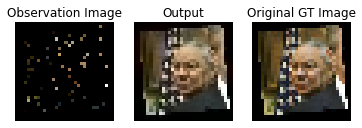

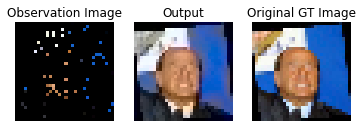

Loss:  -0.4347282053600431
===
Test Epoch  9
Loss:  -0.43367767333984375


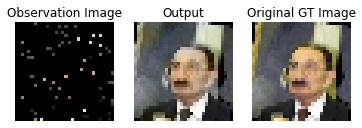

Loss:  -0.43673816323280334


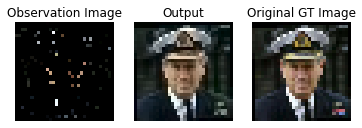

===
Epoch  10
Loss:  -0.4346763491630554


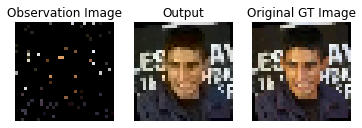

Epoch  10
Loss:  -0.4355703921460394


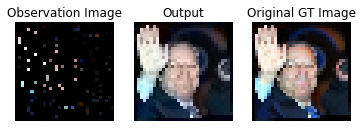

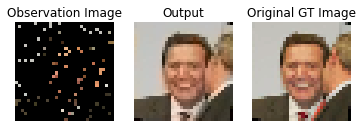

Loss:  -0.435580573000833
===
Test Epoch  10
Loss:  -0.43439674377441406


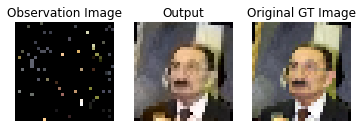

Loss:  -0.4368570148944855


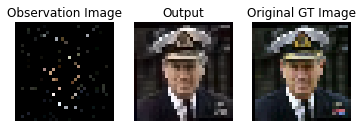

===
Epoch  11
Loss:  -0.43462735414505005


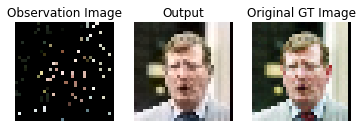

Epoch  11
Loss:  -0.43620185027668135


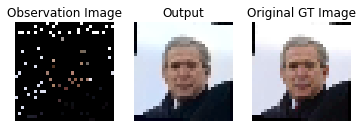

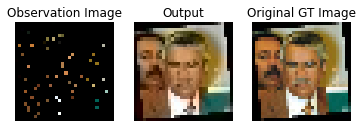

Loss:  -0.4359044243840023
===
Test Epoch  11
Loss:  -0.4371381998062134


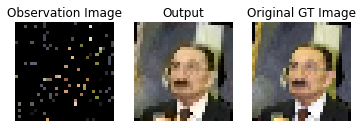

Loss:  -0.43950581550598145


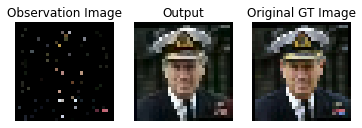

===
Epoch  12
Loss:  -0.43674859404563904


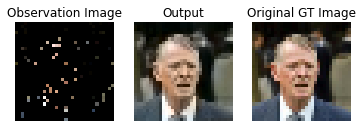

Epoch  12
Loss:  -0.436571102830308


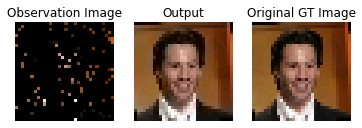

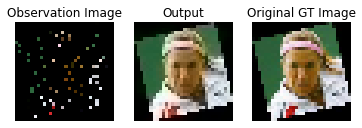

Loss:  -0.4363593610481442
===
Test Epoch  12
Loss:  -0.43811631202697754


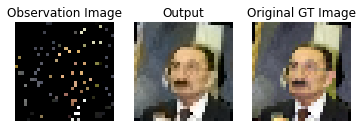

Loss:  -0.4392732083797455


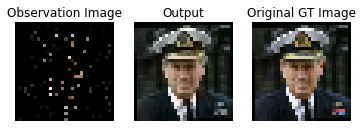

===
Epoch  13
Loss:  -0.4460136294364929


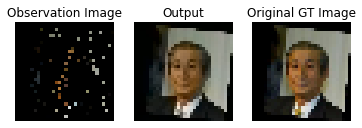

Epoch  13
Loss:  -0.4366958455659857


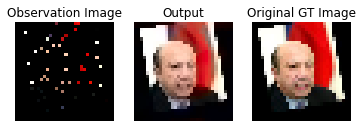

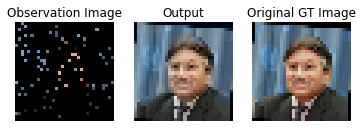

Loss:  -0.4366512917255232
===
Test Epoch  13
Loss:  -0.4380740821361542


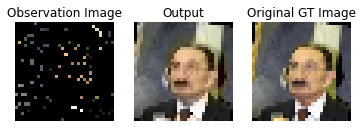

Loss:  -0.4396597445011139


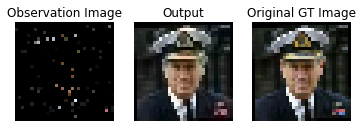

===
Epoch  14
Loss:  -0.43388497829437256


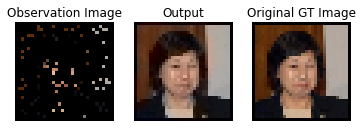

Epoch  14
Loss:  -0.4363769233523317


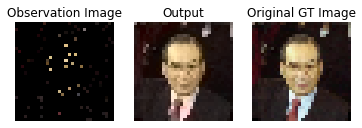

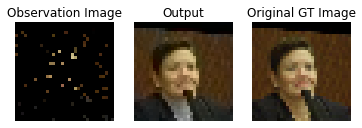

Loss:  -0.43667311178452056
===
Test Epoch  14
Loss:  -0.4391840696334839


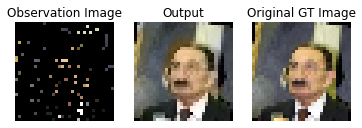

Loss:  -0.43504589796066284


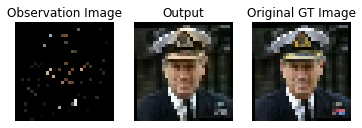

===
Epoch  15
Loss:  -0.441744327545166


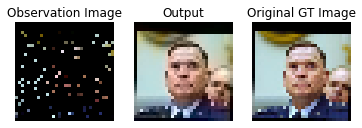

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 30
visualize_freq = 200

losses = []
losses_a = []
losses_b = []

for epoch in range(epochs):
    _loss, _loss_a, _loss_b = 0., 0., 0.

    model.train()
    for i, (color_c, gray_c, obs, preds, preds_gt, coords_obs, coords_pred) in enumerate(train_loader):
        optimizer.zero_grad()
        obs, preds, preds_gt = obs.to(0), preds.to(0), preds_gt.to(0)
        # print(preds_gt.shape)

        query = ((obs[:,:,:40].float(),obs[:,:,40:].float()), preds.float())
        mu, sigma, _, _, loss = model(query, 32 * 32, preds_gt.float())
        mu_a, mu_b = torch.chunk(mu, 2, dim=-1)
        sigma_a, sigma_b = torch.chunk(sigma, 2, dim=-1)

        loss.backward()
        optimizer.step()
        _loss += loss.item()
        if i % visualize_freq == 0:
            print("Epoch ", epoch)
            print("Loss: ", _loss/(i+1))
            # if not os.path.exists("image_outputs"):
            #     os.makedirs("image_outputs")
            visualize(gray_c, color_c, coords_obs, coords_pred, mu_a, mu_b) 
                      #,out_dir = "image_outputs/" + str(epoch) + "_" + str(i) + ".jpg")
    losses.append(_loss/(i+1))
    visualize(gray_c, color_c, coords_obs, coords_pred, mu_a, mu_b)
                      #,out_dir = "image_outputs/" + str(epoch) + "_" + str(i) + ".jpg")
    print("Loss: ", _loss/(i+1))
    print("===")

    # Visualize test data
    print("Test Epoch ", epoch)
    model.eval()
    for i, (color_c, gray_c, obs, preds, preds_gt, coords_obs, coords_pred) in enumerate(test_loader):
        optimizer.zero_grad()
        obs, preds, preds_gt = obs.to(0), preds.to(0), preds_gt.to(0)
        # print(preds_gt.shape)

        query = ((obs[:,:,:40].float(),obs[:,:,40:].float()), preds.float())
        mu, sigma, _, _, loss = model(query, 32 * 32, preds_gt.float())
        mu_a, mu_b = torch.chunk(mu, 2, dim=-1)
        sigma_a, sigma_b = torch.chunk(sigma, 2, dim=-1)

        optimizer.step()    
        print("Loss: ", loss.item())
        visualize(gray_c, color_c, coords_obs, coords_pred, mu_a, mu_b)
        # only test a few
        if i == 1:
            break
    print("===")